### **Loading the Dataset**


In [17]:
import pandas as pd

# Load the dataset from the file path
file_path = "spam_ham_dataset.csv"
df = pd.read_csv(file_path)

# Display the first few rows to verify the dataset
print(df.head())


   Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\r\nthis deal is t...   

   label_num  
0          0  
1          0  
2          0  
3          1  
4          0  


### Checking balance of dataset

In [18]:
# Calculate the distribution of target labels
label_counts = df['label_num'].value_counts()

# Display the distribution
print("Label Distribution:")
print(label_counts)

# Check if the dataset is balanced
if label_counts.min() / label_counts.max() < 0.5:
    print("The dataset is imbalanced.")
else:
    print("The dataset is balanced.")

Label Distribution:
label_num
0    3672
1    1499
Name: count, dtype: int64
The dataset is imbalanced.


### **Data Cleaning**
1. Converting to lowercase 
2. Removing email headers
3. Removing punctation and digits
4. Removing whitespaces
5. Removal of stopwords

In [2]:
import re
import string
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords if not already present
nltk.download('stopwords')

# Define a cleaning function for text data
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove email headers (if any) and newlines
    text = re.sub(r'subject: ', '', text)
    text = re.sub(r'\n', ' ', text)
    # Remove punctuation and digits
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r'\d+', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text

# Apply cleaning to the 'text' column
df['clean_text'] = df['text'].apply(clean_text)

# Display the cleaned text
print(df[['text', 'clean_text']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prady\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                text  \
0  Subject: enron methanol ; meter # : 988291\r\n...   
1  Subject: hpl nom for january 9 , 2001\r\n( see...   
2  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3  Subject: photoshop , windows , office . cheap ...   
4  Subject: re : indian springs\r\nthis deal is t...   

                                          clean_text  
0  enron methanol meter follow note gave monday p...  
1  hpl nom january see attached file hplnol xls h...  
2  neon retreat ho ho ho around wonderful time ye...  
3  photoshop windows office cheap main trending a...  
4  indian springs deal book teco pvr revenue unde...  


### **Creating corpus and vectors**

In [3]:
# Tokenize the cleaned text into words
df['tokens'] = df['clean_text'].apply(lambda x: x.split())

# Create the corpus as a list of token lists
corpus = df['tokens'].tolist()

# Display the tokenized version of the first email
print(corpus[0])


['enron', 'methanol', 'meter', 'follow', 'note', 'gave', 'monday', 'preliminary', 'flow', 'data', 'provided', 'daren', 'please', 'override', 'pop', 'daily', 'volume', 'presently', 'zero', 'reflect', 'daily', 'activity', 'obtain', 'gas', 'control', 'change', 'needed', 'asap', 'economics', 'purposes']


### **Creating word embeddings for each email**

Gets the embedding of each word in an email and returns a `average vector` of all words in the email to represent it<br/>
Also checking the cosine similarity between first and second email 

In [8]:
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load pretrained GloVe model
glove_model = api.load("glove-wiki-gigaword-50")

def get_embedding(text, model):
    words = text.lower().split()
    word_vectors = [model[word] for word in words if word in model]
    if not word_vectors:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

# Compute embeddings for the first and second emails in the corpus
embedding1 = get_embedding(" ".join(corpus[0]), glove_model)
embedding2 = get_embedding(" ".join(corpus[1]), glove_model)

# Compute cosine similarity between the two embeddings
similarity = cosine_similarity([embedding1], [embedding2])
print("Cosine similarity between first and second emails:", similarity[0][0])


Cosine similarity between first and second emails: 0.5875887


### **Data Visualisation**
#### 1. Word Cloud

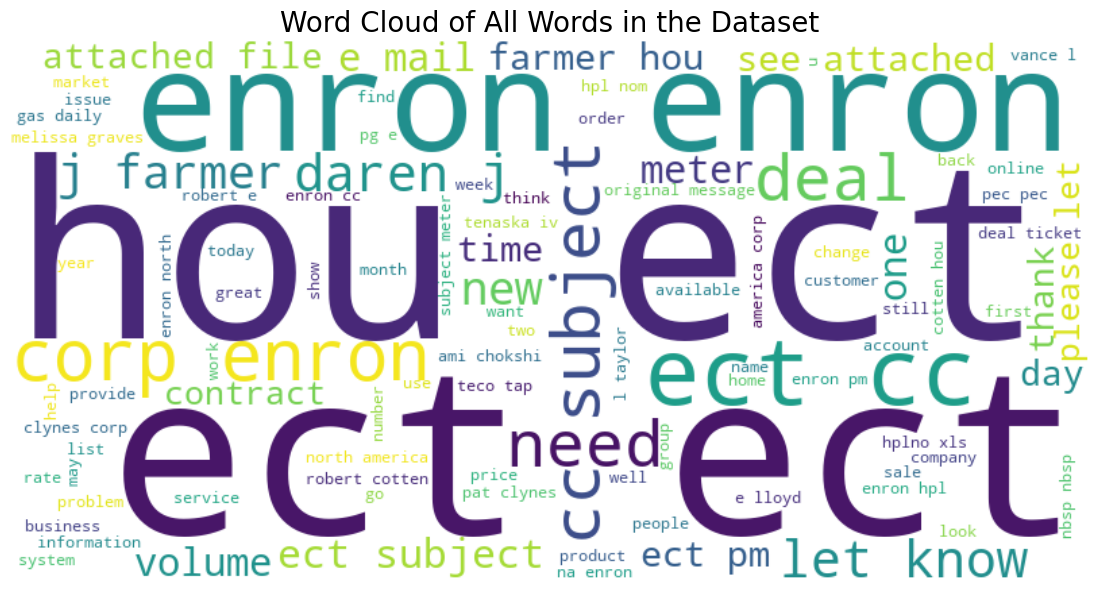

In [9]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt

# Flatten the list of tokens
all_words = [word for tokens in corpus for word in tokens]

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', 
                      max_words=100, colormap='viridis', 
                      contour_width=1, contour_color='steelblue')
wordcloud.generate(' '.join(all_words))

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Words in the Dataset', fontsize=20)
plt.tight_layout()
plt.show()

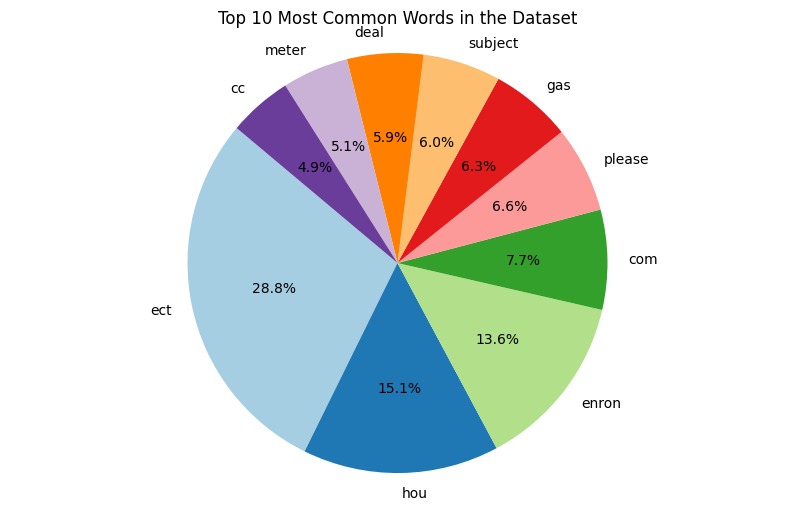

In [10]:
from collections import Counter

import matplotlib.pyplot as plt

# Count the frequency of each word in the dataset
word_freq = Counter(all_words)

# Get the most common words and their frequencies
most_common_words = word_freq.most_common(10)
words, frequencies = zip(*most_common_words)

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(frequencies, labels=words, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Top 10 Most Common Words in the Dataset')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### **Training the model**
Though model requires binary classification we can use LogisticRegression as:

- **Word2Vec:**<br/> is an unsupervised method that learns dense vector representations of words from raw text. It captures semantic relationships between words

- **Supervised Classification:**<br/>
Once we have a fixed-size vector for each email, we need a classifier to learn the relationship between these feature vectors and the email categories. Logistic regression is a popular and simple classifier for binary classification tasks

- **Choice of Logistic Regression:**<br/>
Logistic regression is widely used because it is easy to interpret, computationally efficient, and often performs well on linearly separable data. 

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Create a new column to store the average vector for each email
df['avg_vector'] = df['clean_text'].apply(lambda x: get_embedding(x, glove_model))

# Prepare feature matrix (X) and target vector (y)
X = np.vstack(df['avg_vector'].values)
y = df['label_num'].values

# Split the dataset into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic Regression classifier
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9410628019323671

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       742
           1       0.91      0.88      0.89       293

    accuracy                           0.94      1035
   macro avg       0.93      0.92      0.93      1035
weighted avg       0.94      0.94      0.94      1035



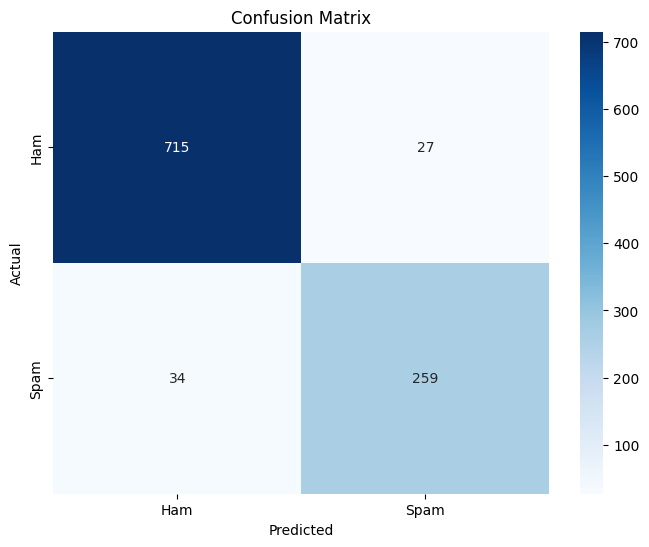

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### **Sample prediction**

In [ ]:
# Sample texts to test the model
sample_texts = [
    # Spam-like text
    "URGENT: You've won a free iPhone! Click here to claim your prize now! Limited time offer.",
    "Congratulations! You have been selected to receive $5000. Send your bank details to claim reward.",
    "Buy cheap medications online! Viagra, Cialis at lowest prices. No prescription needed.",
    
    # Ham-like text
    "Hi there, can we reschedule our meeting to tomorrow at 2pm? Thanks.",
    "Please find attached the report we discussed yesterday. Let me know if you have any questions.",
    "The quarterly financial statements have been updated. Please review and provide feedback."
]

# Function to preprocess and get embedding for a new text
def preprocess_and_embed(text):
    # Clean the text using the previously defined function
    cleaned_text = clean_text(text)
    # Get embedding
    embedding = get_embedding(cleaned_text, glove_model)
    return cleaned_text, embedding

# Make predictions
print("Prediction Results (0: Ham, 1: Spam):\n")
for text in sample_texts:
    cleaned_text, embedding = preprocess_and_embed(text)
    prediction = clf.predict([embedding])[0]
    probability = clf.predict_proba([embedding])[0]
    
    print(f"Text: {text}") 
    print(f"Prediction: {'Spam' if prediction == 1 else 'Ham'}")
    print(f"Probability: {probability[prediction]:.4f}")
    print("-" * 80)

Prediction Results (0: Ham, 1: Spam):

Text: URGENT: You've won a free iPhone! Click here to claim your prize now! Limited time offer.
Prediction: Spam
Probability: 0.9691
--------------------------------------------------------------------------------
Text: Congratulations! You have been selected to receive $5000. Send your bank details to claim reward.
Prediction: Spam
Probability: 0.6828
--------------------------------------------------------------------------------
Text: Buy cheap medications online! Viagra, Cialis at lowest prices. No prescription needed.
Prediction: Spam
Probability: 1.0000
--------------------------------------------------------------------------------
Text: Hi there, can we reschedule our meeting to tomorrow at 2pm? Thanks.
Prediction: Ham
Probability: 0.9861
--------------------------------------------------------------------------------
Text: Please find attached the report we discussed yesterday. Let me know if you have any questions.
Prediction: Ham
Probab